# Decision Tree, Random Forest, Bagging, Boosting, Logistic Regression

## Data Preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import classification_report
import sklearn.model_selection as cv
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
import itertools

import warnings
warnings.filterwarnings("ignore")

In [4]:
data_train=pd.read_csv('tiny_sample_train.csv')
data_train.head()

,Unnamed: 0,X,duration_seconds,miles,fare,tip,tolls,extra_charges,trip_total,payment_type,...,gps_pings_dropoff_end,region_pickup,region_dropoff,tip_flag,ride_type,flag_overnight,total_no_tip,start_hour,flag_weekend,outlier
0,385586,1357181,280,0.8,5.0,0.0,0,2.55,7.55,Mobile,...,9316,North,North,0,Rideshare,0,7.55,16,0,False
1,19325,1119229,354,0.8,5.0,1.0,0,2.55,8.55,Mobile,...,3616,Downtown,Downtown,1,Rideshare,0,7.55,19,0,False
2,316363,1076648,865,2.5,7.5,0.0,0,2.55,10.05,Mobile,...,12210,Downtown,Downtown,0,Rideshare,0,10.05,17,0,False
3,393267,4114739,1586,4.5,12.5,0.0,0,2.55,15.05,Mobile,...,2417,Downtown,Downtown,0,Rideshare,0,15.05,18,0,False
4,715,1970544,1398,5.8,5.0,0.0,0,2.55,7.55,Mobile,...,5823,Downtown,North,0,Rideshare,0,7.55,21,1,False


In [5]:
data_test=pd.read_csv('tiny_sample_test.csv')
data_test.head()

,Unnamed: 0,X,duration_seconds,miles,fare,tip,tolls,extra_charges,trip_total,payment_type,...,gps_pings_dropoff_end,region_pickup,region_dropoff,tip_flag,ride_type,flag_overnight,total_no_tip,start_hour,flag_weekend,outlier
0,3,4737030,1197,3.40,10.0,0.0,0,2.55,12.55,Mobile,...,3393,Downtown,South,0,Rideshare,0,12.55,19,0,False
1,4,2437426,799,3.70,7.5,0.0,0,2.55,10.05,Mobile,...,3897,North,Downtown,0,Rideshare,0,10.05,21,0,False
2,7,569410,573,1.26,7.0,0.0,0,1.00,8.00,Cash,...,4419,Downtown,Downtown,0,Taxi,0,8.00,19,0,False
3,8,1776570,2631,10.60,12.5,0.0,0,2.55,15.05,Mobile,...,6791,West,North,0,Rideshare,0,15.05,16,0,False
4,9,1669319,407,0.90,5.0,0.0,0,2.55,7.55,Mobile,...,3152,Downtown,Downtown,0,Rideshare,0,7.55,14,0,False


In [6]:
data_train.dtypes

Unnamed: 0                       int64
X                                int64
duration_seconds                 int64
miles                          float64
fare                           float64
tip                            float64
tolls                            int64
extra_charges                  float64
trip_total                     float64
payment_type                    object
start_month                      int64
start_weekday                   object
speed_pickup_start             float64
speed_category_pickup_start     object
bus_count_pickup_start           int64
gps_pings_pickup_start           int64
speed_dropoff_end              float64
speed_category_dropoff_end      object
bus_count_dropoff_end            int64
gps_pings_dropoff_end            int64
region_pickup                   object
region_dropoff                  object
tip_flag                         int64
ride_type                       object
flag_overnight                   int64
total_no_tip             

In [7]:
# Instantiate labelencoder object and apply on categorical columns in training data
le = LabelEncoder()
cat_data_train = data_train[['start_weekday','payment_type','ride_type','speed_category_pickup_start','speed_category_dropoff_end','outlier','region_pickup','region_dropoff']]
original = cat_data_train
mask = cat_data_train.isnull()
cat_data_encoded_train = cat_data_train.astype(str).apply(le.fit_transform)
cat_data_encoded_train.where(~mask,original)

# Exclude the columnes of 'speed_category_pickup_start','speed_category_dropoff_end','outlier'
cat_data_encoded_train = cat_data_encoded_train[['start_weekday','payment_type','ride_type','region_pickup','region_dropoff']]

In [9]:
# Instantiate labelencoder object and apply on categorical columns in test data
le_test = LabelEncoder()
cat_data_test = data_test[['start_weekday','payment_type','ride_type','speed_category_pickup_start','speed_category_dropoff_end','outlier','region_pickup','region_dropoff']]
original_test = cat_data_test
mask_test = cat_data_test.isnull()
cat_data_encoded_test = cat_data_test.astype(str).apply(le_test.fit_transform)
cat_data_encoded_test.where(~mask_test,original_test)

# Exclude the columnes of 'speed_category_pickup_start','speed_category_dropoff_end','outlier'
cat_data_encoded_test = cat_data_encoded_test[['start_weekday','payment_type','ride_type','region_pickup','region_dropoff']]

In [115]:
# Exclude columns of 'tip','tip_flag','total_no_tip','region_pickup','region_dropoff','tolls','extra_charges', 'bus_count_pickup_start','gps_pings_pickup_start'
cols = ['duration_seconds','miles','fare','speed_pickup_start','speed_dropoff_end','flag_weekend','flag_overnight','total_no_tip','start_hour','start_month']
x_train = pd.concat([data_train[cols], cat_data_encoded_train], axis=1)
x_test = pd.concat([data_test[cols], cat_data_encoded_test], axis=1)

In [116]:
# Swap the tip_flags for training and test data
y_train = data_train.tip_flag
y_train = y_train.replace((1,0),(0,1))
y_test = data_test.tip_flag
y_test = y_test.replace((1,0),(0,1))

## Decision (Classification) Tree

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [13]:
# Create a grid search object for "max_depth=1-10"
tree_para = {'max_depth':range(1,10)}
clf = GridSearchCV(DecisionTreeClassifier(random_state=232323), param_grid = tree_para, cv=3)
clf.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False,
                                              random_state=232323,
                                              splitter='best'),
             iid='warn', n_jobs=None, param_grid={'max_depth': range(1, 10)},
             pre_dispatch='2*n_jobs', refit=True

In [14]:
# View the best parameters
print (clf.best_score_, clf.best_params_)

0.8398685714285714 {'max_depth': 3}


In [15]:
# Use cross validation to evaulate the model
CV_Result = cross_val_score(clf, x_train, y_train, cv=3, n_jobs=-1)
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())


[0.83994617 0.8398776  0.83978194]

0.8398685711810584

6.734990859165232e-05


In [136]:
# Instantiate a DecisionTreeClassifier
treeclf = DecisionTreeClassifier(criterion="gini", max_depth=3, random_state=232323)

# Fit tree to the training set and predict the response
treeclf = treeclf.fit(x_train, y_train)
y_pred_tree = treeclf.predict(x_test)

# Compute test set accuracy for model evaluation
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_tree))
print("Precision:",metrics.precision_score(y_test, y_pred_tree))
print("Recall:",metrics.recall_score(y_test, y_pred_tree))
print("f1-score:",metrics.f1_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

Accuracy: 0.8397533333333334
Precision: 0.8337583046477696
Recall: 0.9952147851303252
f1-score: 0.9073600881807706
              precision    recall  f1-score   support

           0       0.94      0.26      0.41     31719
           1       0.83      1.00      0.91    118281

    accuracy                           0.84    150000
   macro avg       0.88      0.63      0.66    150000
weighted avg       0.86      0.84      0.80    150000



In [84]:
# Compute train set accuracy for model evaluation
print("Accuracy:",metrics.accuracy_score(y_train, treeclf.predict(x_train)))
print("Precision:",metrics.precision_score(y_train, treeclf.predict(x_train)))
print("Recall:",metrics.recall_score(y_train, treeclf.predict(x_train)))
print("f1-score:",metrics.f1_score(y_train, treeclf.predict(x_train)))
print(classification_report(y_train, treeclf.predict(x_train)))

Accuracy: 0.8398857142857142
Precision: 0.8337425230567534
Recall: 0.9954490280268855
f1-score: 0.9074480840564295
              precision    recall  f1-score   support

           0       0.94      0.26      0.41     74015
           1       0.83      1.00      0.91    275985

    accuracy                           0.84    350000
   macro avg       0.89      0.63      0.66    350000
weighted avg       0.86      0.84      0.80    350000



In [96]:
# Create a dataframe of performance measures
import pandas as pd 
measures = {'Accuracy':[metrics.accuracy_score(y_train, treeclf.predict(x_train)), metrics.accuracy_score(y_test, y_pred)], 
            'Precision':[metrics.precision_score(y_train, treeclf.predict(x_train)), metrics.precision_score(y_test, y_pred)],
           'Recall':[metrics.recall_score(y_train, treeclf.predict(x_train)),metrics.recall_score(y_test, y_pred)],
           'f1-score':[metrics.f1_score(y_train, treeclf.predict(x_train)),metrics.f1_score(y_test, y_pred)]} 
measures_df = pd.DataFrame(measures, index =['Train', 'Test']).transpose()
measures_df 

,Train,Test
Accuracy,0.839886,0.839753
Precision,0.833743,0.833758
Recall,0.995449,0.995215
f1-score,0.907448,0.907360


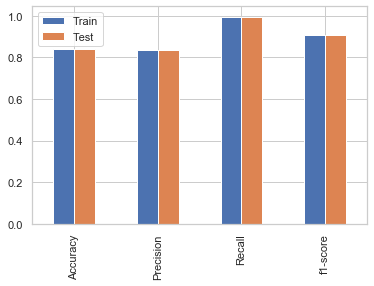

In [99]:
# Plot the train-test validation
measures_df.plot(kind='bar', legend=True)

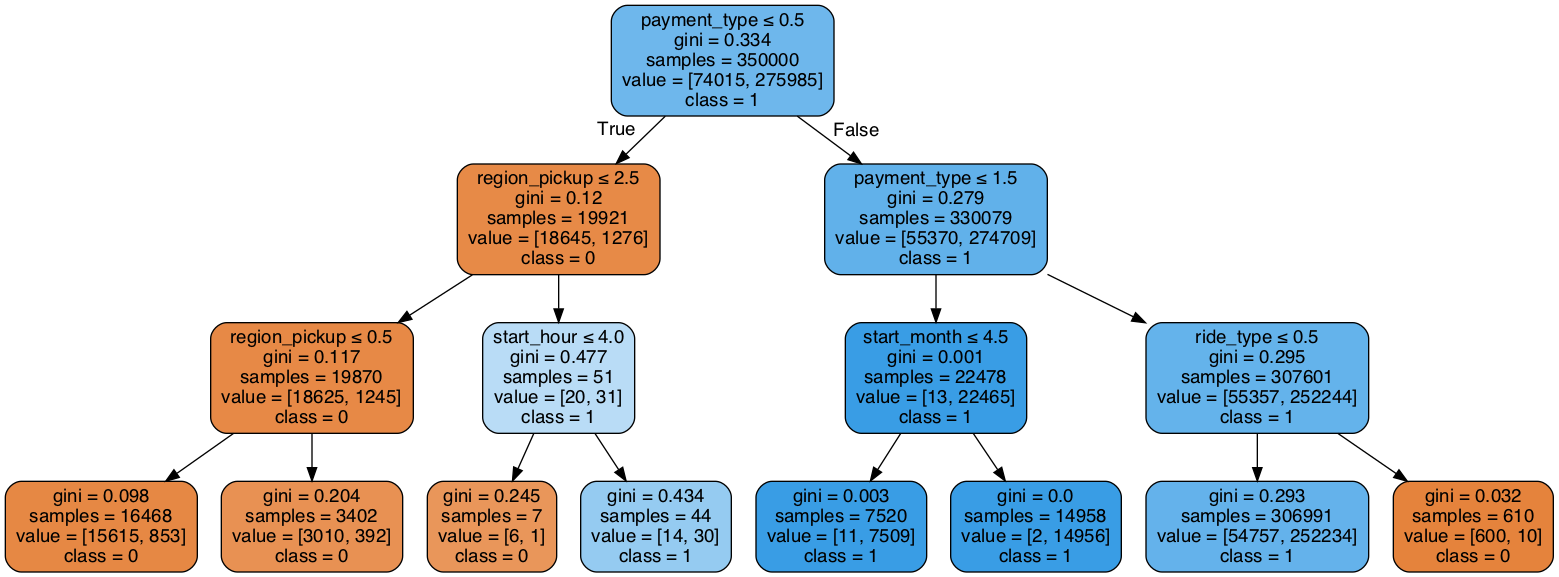

In [32]:
# Visualize the tree model
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(treeclf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = x_train.columns, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decisionTree.png')
Image(graph.create_png())

Text(0.5, 257.44, 'Predicted label')

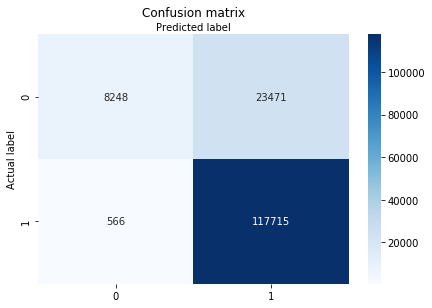

In [33]:
# Model evaluation using confusion matrix
from sklearn import metrics
import seaborn as sns
%matplotlib inline

cnf_matrix = metrics.confusion_matrix(y_test, y_pred_tree)

# Visualize confusion matrix
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 1.0, 'Tree Decision Region Boundary')

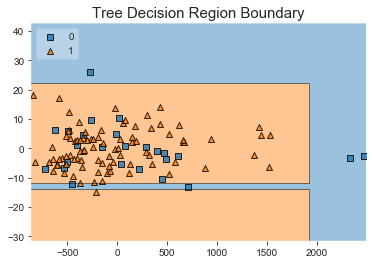

In [71]:
# Plot decison area with PCA (2 components)
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

# Random sampling
x_train_sample = x_train.sample(frac =.00032, random_state=232323)
y_train_sample = y_train.sample(frac =.00032, random_state=232323)

pca = PCA(n_components = 2)
x_train2 = pca.fit_transform(x_train_sample)

x = np.array(x_train2)
y = np.array(y_train_sample)

treeclf.fit(x_train2, y_train_sample)
plot_decision_regions(X=x, y=y, clf=treeclf, legend=2, zoom_factor=0.06)
plt.title('Tree Decision Region Boundary', size=15)

## Random Forest

In [ ]:
# Grid search 
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=-1, oob_score = True) 
param_grid = {'n_estimators': [100,150,200], 'max_features': ['sqrt', 'log2']}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3)
CV_rfc.fit(x_train, y_train)
print(CV_rfc.best_params_)

#### Performance measures

In [137]:
from sklearn.ensemble import RandomForestClassifier

# Initiatie RF with 10 decision trees (at each split, choose different predictors)
rf = RandomForestClassifier(n_estimators = 200, # Number of trees to grow
                            max_features = 'log2', # Number of different predictors chosen at each step
                            random_state = 232323, 
                            n_jobs = -1)

forestmodel= rf.fit(x_train, y_train)
y_pred_rf = forestmodel.predict(x_test)

# Compute test set accuracy  
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))
print("Precision:",metrics.precision_score(y_test, y_pred_rf))
print("Recall:",metrics.recall_score(y_test, y_pred_rf))
print("f1-score:",metrics.f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.83764
Precision: 0.8350778056037158
Recall: 0.989524944834758
f1-score: 0.905764632136141
              precision    recall  f1-score   support

           0       0.87      0.27      0.41     31719
           1       0.84      0.99      0.91    118281

    accuracy                           0.84    150000
   macro avg       0.85      0.63      0.66    150000
weighted avg       0.84      0.84      0.80    150000



In [119]:
# Compute train set accuracy for model evaluation
print("Accuracy:",metrics.accuracy_score(y_train, rf.predict(x_train)))
print("Precision:",metrics.precision_score(y_train, rf.predict(x_train)))
print("Recall:",metrics.recall_score(y_train, rf.predict(x_train)))
print("f1-score:",metrics.f1_score(y_train, rf.predict(x_train)))
print(classification_report(y_train, rf.predict(x_train)))

Accuracy: 0.9999914285714285
Precision: 0.9999927532555999
Recall: 0.9999963766146711
f1-score: 0.9999945649318533
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     74015
           1       1.00      1.00      1.00    275985

    accuracy                           1.00    350000
   macro avg       1.00      1.00      1.00    350000
weighted avg       1.00      1.00      1.00    350000



In [138]:
# Create a dataframe of performance measures
import pandas as pd 
measures = {'Accuracy':[metrics.accuracy_score(y_train, rf.predict(x_train)), metrics.accuracy_score(y_test, y_pred_rf)], 
            'Precision':[metrics.precision_score(y_train, rf.predict(x_train)), metrics.precision_score(y_test, y_pred_rf)],
           'Recall':[metrics.recall_score(y_train, rf.predict(x_train)),metrics.recall_score(y_test, y_pred_rf)],
           'f1-score':[metrics.f1_score(y_train, rf.predict(x_train)),metrics.f1_score(y_test, y_pred_rf)]} 
measures_df = pd.DataFrame(measures, index =['Train', 'Test']).transpose()
measures_df 

,Train,Test
Accuracy,0.999991,0.837640
Precision,0.999993,0.835078
Recall,0.999996,0.989525
f1-score,0.999995,0.905765


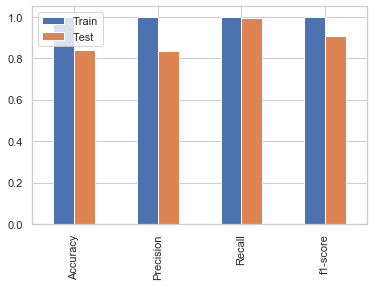

In [104]:
# Plot the train-test validation
measures_df.plot(kind='bar', legend=True)

Text(0.5, 257.44, 'Predicted label')

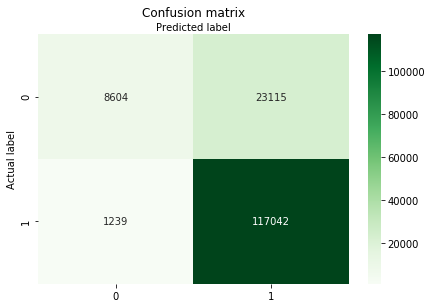

In [41]:
# Model evaluation using confusion matrix
from sklearn import metrics
import seaborn as sns
%matplotlib inline

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Greens" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

#### Important Features

In [39]:
# Find important features
feature_imp = pd.Series(forestmodel.feature_importances_, index=x_train.columns).sort_values(ascending=False)
feature_imp

payment_type          0.170882
duration_seconds      0.142501
speed_pickup_start    0.134883
speed_dropoff_end     0.134816
miles                 0.109803
start_hour            0.070386
start_month           0.065080
start_weekday         0.041537
total_no_tip          0.039747
fare                  0.025344
ride_type             0.022103
region_pickup         0.016749
region_dropoff        0.015881
flag_weekend          0.009187
flag_overnight        0.001102
dtype: float64

No handles with labels found to put in legend.


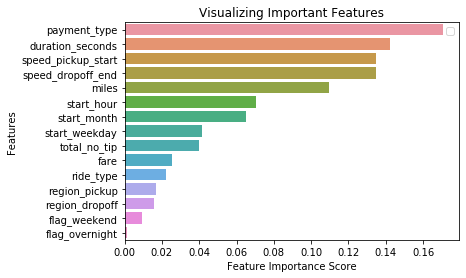

In [40]:
feature_imp = pd.Series(forestmodel.feature_importances_, index=x_train.columns).sort_values(ascending=False)

# Visualize important features
import seaborn as sns
%matplotlib inline

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

#### Decision boundary

Text(0.5, 1.0, 'Random Forest Decision Region Boundary')

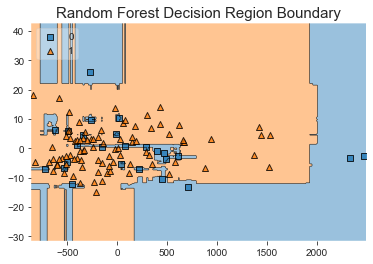

In [70]:
# Plot decison area with PCA (2 components)
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

# Random sampling
x_train_sample = x_train.sample(frac =.00032, random_state=232323)
y_train_sample = y_train.sample(frac =.00032, random_state=232323)

pca = PCA(n_components = 2)
x_train2 = pca.fit_transform(x_train_sample)

x = np.array(x_train2)
y = np.array(y_train_sample)

rf.fit(x_train2, y_train_sample)
plot_decision_regions(X=x, y=y, clf=rf, legend=2, zoom_factor=0.06)
plt.title('Random Forest Decision Region Boundary', size=15)

### Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression

# Initialize classifier
lgclf = LogisticRegression(random_state=232323)
lgclf.fit(x_train, y_train)
y_pred=lgclf.predict(x_test)

Text(0.5, 257.44, 'Predicted label')

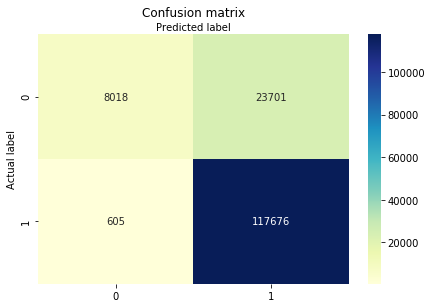

In [45]:
# Model evaluation using confusion matrix
from sklearn import metrics
import seaborn as sns
%matplotlib inline

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [46]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("f1-score:",metrics.f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.83796
Precision: 0.8323560409401812
Recall: 0.9948850618442523
f1-score: 0.906392254426977
              precision    recall  f1-score   support

           0       0.93      0.25      0.40     31719
           1       0.83      0.99      0.91    118281

    accuracy                           0.84    150000
   macro avg       0.88      0.62      0.65    150000
weighted avg       0.85      0.84      0.80    150000



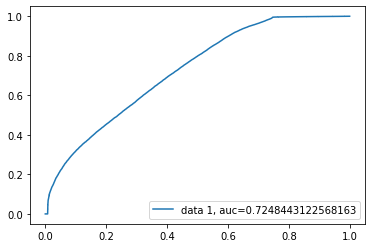

In [47]:
# ROC curve
y_pred_proba = lgclf.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Text(0.5, 1.0, 'Logistic Decision Region Boundary')

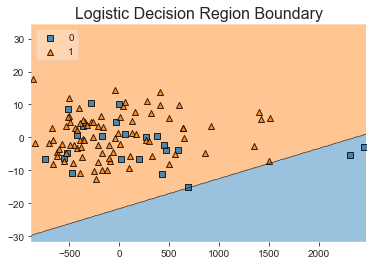

In [69]:
# Plot decison area with PCA (2 components)
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

# Random sampling
x_train_sample = x_train.sample(frac =.00031, random_state=232323)
y_train_sample = y_train.sample(frac =.00031, random_state=232323)

pca = PCA(n_components = 2)
x_train2 = pca.fit_transform(x_train_sample)

x = np.array(x_train2)
y = np.array(y_train_sample)

lgclf.fit(x_train2, y_train_sample)
plot_decision_regions(X=x, y=y, clf=lgclf, legend=2, zoom_factor=0.06)
plt.title('Logistic Decision Region Boundary', size=16)

### Bagging

In [139]:
from sklearn.ensemble import BaggingClassifier

# Initialize Bagging Classifier
Baggingclf = BaggingClassifier(base_estimator = treeclf, 
                            n_estimators = 200, 
                            max_samples = 1.0, 
                            n_jobs= -1,
                            random_state = 232323)

BaggingModel = Baggingclf.fit(x_train, y_train)
y_pred_bagging = BaggingModel.predict(x_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_bagging))
print("Precision:",metrics.precision_score(y_test, y_pred_bagging))
print("Recall:",metrics.recall_score(y_test, y_pred_bagging))
print("f1-score:",metrics.f1_score(y_test, y_pred_bagging))
print(classification_report(y_test, y_pred_bagging))

Accuracy: 0.8397533333333334
Precision: 0.8337677607627034
Recall: 0.9951978762438599
f1-score: 0.9073586600016187
              precision    recall  f1-score   support

           0       0.94      0.26      0.41     31719
           1       0.83      1.00      0.91    118281

    accuracy                           0.84    150000
   macro avg       0.88      0.63      0.66    150000
weighted avg       0.86      0.84      0.80    150000



Text(0.5, 1.0, 'Bagging Decision Region Boundary')

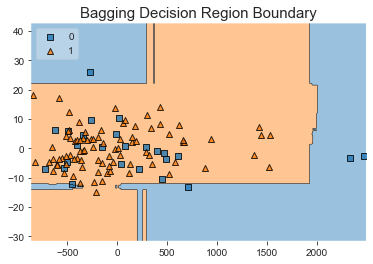

In [72]:
# Plot decison area with PCA (2 components)
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

# Random sampling
x_train_sample = x_train.sample(frac =.00032, random_state=232323)
y_train_sample = y_train.sample(frac =.00032, random_state=232323)

pca = PCA(n_components = 2)
x_train2 = pca.fit_transform(x_train_sample)

x = np.array(x_train2)
y = np.array(y_train_sample)

Baggingclf.fit(x_train2, y_train_sample)
plot_decision_regions(X=x, y=y, clf=Baggingclf, legend=2, zoom_factor=0.06)
plt.title('Bagging Decision Region Boundary', size=15)

### Boosting

In [141]:
from sklearn.ensemble import AdaBoostClassifier

# Create adaboost classifer
abc = AdaBoostClassifier(n_estimators=50,learning_rate=0.01, random_state=232323)
BoostingModel = abc.fit(x_train, y_train)
y_pred_abc = BoostingModel.predict(x_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_abc))
print("Precision:",metrics.precision_score(y_test, y_pred_abc))
print("Recall:",metrics.recall_score(y_test, y_pred_abc))
print("f1-score:",metrics.f1_score(y_test, y_pred_abc))
print(classification_report(y_test, y_pred_abc))

Accuracy: 0.8381466666666667
Precision: 0.8323657320651981
Recall: 0.9951640584709294
f1-score: 0.9065137699463989
              precision    recall  f1-score   support

           0       0.93      0.25      0.40     31719
           1       0.83      1.00      0.91    118281

    accuracy                           0.84    150000
   macro avg       0.88      0.62      0.65    150000
weighted avg       0.85      0.84      0.80    150000



#### Weak Classifier Plot

Accuracy =  0.7828571428571428


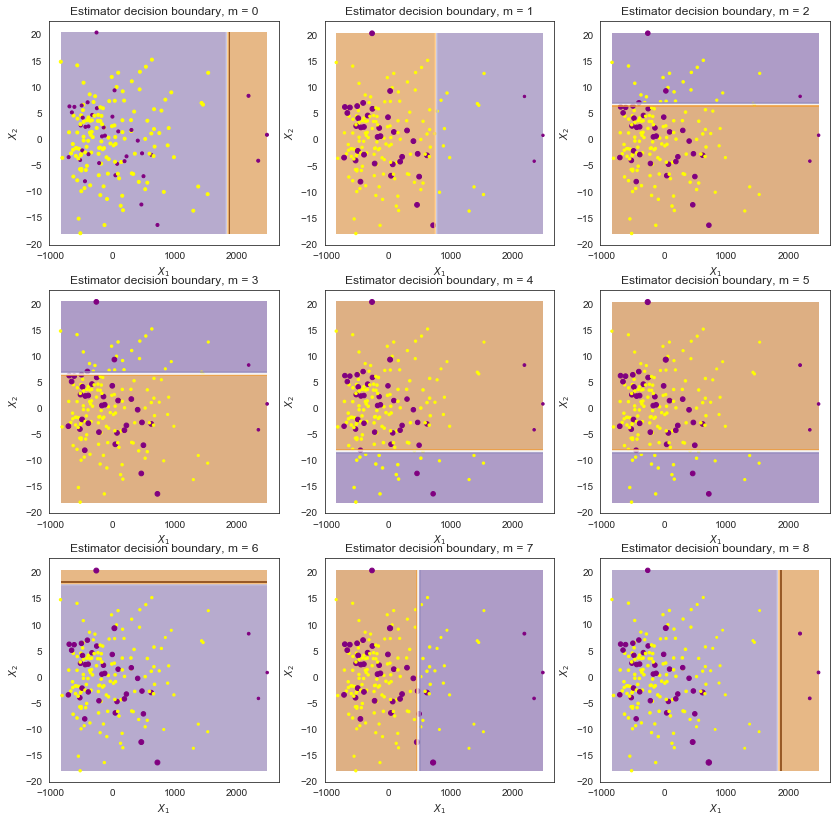

In [58]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
sns.set_style('white')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA

# Random sampling
x_train_sample = x_train.sample(frac =.0005, random_state=232323)
y_train_sample = y_train.sample(frac =.0005, random_state=232323)

pca = PCA(n_components = 2)
x_train2 = pca.fit_transform(x_train_sample)

X = np.array(x_train2)
y = np.array(y_train_sample)

def plot_decision_boundary(classifier, X, y, N = 10, scatter_weights = np.ones(len(y)) , ax = None ):
    '''Utility function to plot decision boundary and scatter plot of data'''
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))

    
    #Check what methods are available
    if hasattr(classifier, "decision_function"):
        zz = np.array( [classifier.decision_function(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
    elif hasattr(classifier, "predict_proba"):
        zz = np.array( [classifier.predict_proba(np.array([xi,yi]).reshape(1,-1))[:,1] for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
    else :
        zz = np.array( [classifier(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
            
    # reshape result and plot
    Z = zz.reshape(xx.shape)
    cm_bright = ListedColormap(['Purple', 'Yellow'])
    
    #Get current axis and plot
    if ax is None:
        ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap='PuOr', alpha=.5)
    ax.contour(xx, yy, Z,  2, cmap='PuOr')
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright, s = scatter_weights * 40)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')
    
def AdaBoost_scratch(X,y, M=10, learning_rate = 1):
    #Initialization of utility variables
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [], [],[],[],[]

    #Initialize the sample weights
    sample_weight = np.ones(N) / N
    sample_weight_list.append(sample_weight.copy())

    #For m = 1 to M
    for m in range(M):   

        #Fit a classifier
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict = estimator.predict(X)

        #Misclassifications
        incorrect = (y_predict != y)

        #Estimator error
        estimator_error = np.mean( np.average(incorrect, weights=sample_weight, axis=0))
        
        #Boost estimator weights
        estimator_weight =  learning_rate * np.log((1. - estimator_error) / estimator_error)

        #Boost sample weights
        sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))

        #Save iteration values
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error.copy())
        estimator_weight_list.append(estimator_weight.copy())
        sample_weight_list.append(sample_weight.copy())
        

    #Convert to np array for convenience   
    estimator_list = np.asarray(estimator_list)
    y_predict_list = np.asarray(y_predict_list)
    estimator_error_list = np.asarray(estimator_error_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)

    #Predictions
    preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
    print('Accuracy = ', (preds == y).sum() / N) 
    
    return estimator_list, estimator_weight_list, sample_weight_list

def plot_AdaBoost_scratch_boundary(estimators,estimator_weights, X, y, N = 10,ax = None ):
    
    def AdaBoost_scratch_classify(x_temp, est,est_weights ):
        '''Return classification prediction for a given point X and a previously fitted AdaBoost'''
        temp_pred = np.asarray( [ (e.predict(x_temp)).T* w for e, w in zip(est,est_weights )]  ) / est_weights.sum()
        return np.sign(temp_pred.sum(axis = 0))
    
    
    '''Utility function to plot decision boundary and scatter plot of data'''
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))


    zz = np.array( [AdaBoost_scratch_classify(np.array([xi,yi]).reshape(1,-1), estimators,estimator_weights ) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
            
    # reshape result and plot
    Z = zz.reshape(xx.shape)
    cm_bright = ListedColormap(['Purple', 'Yellow'])
    
    if ax is None:
        ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap='PuOr', alpha=.5)
    ax.contour(xx, yy, Z,  2, cmap='PuOr')
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')
    
estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X,y, M=10, learning_rate = 1)

fig = plt.figure(figsize = (14,14))
for m in range(0,9):
    fig.add_subplot(3,3,m+1)
    s_weights = (sample_weight_list[m,:] / sample_weight_list[m,:].sum() ) * 40
    plot_decision_boundary(estimator_list[m], X,y,N = 50, scatter_weights =s_weights )
    plt.title('Estimator decision boundary, m = {}'.format(m))
    

#### Decision Boundary

In [73]:
# Plot decison area with PCA (2 components)
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

# Random sampling
x_train_sample = x_train.sample(frac =.00032, random_state=232323)
y_train_sample = y_train.sample(frac =.00032, random_state=232323)

pca = PCA(n_components = 2)
x_train2 = pca.fit_transform(x_train_sample)

pca.explained_variance_ratio_

array([9.99628318e-01, 1.35201129e-04])

Text(0.5, 1.0, 'Boosting Decision Region Boundary')

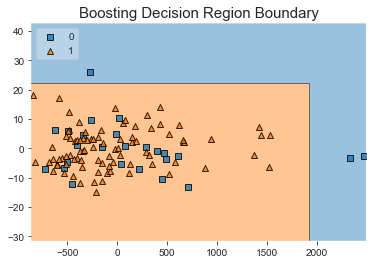

In [74]:
x = np.array(x_train2)
y = np.array(y_train_sample)

abc.fit(x_train2, y_train_sample)
plot_decision_regions(X=x, y=y, clf=abc, legend=2, zoom_factor=0.06)
plt.title('Boosting Decision Region Boundary', size=15)

## Comparison of tree-family models

#### Train-test Performance 

In [143]:
# Create a dataframe for all performance matrics
# Training performance
import pandas as pd 
measures_train = {'Accuracy':[metrics.accuracy_score(y_train, treeclf.predict(x_train)), metrics.accuracy_score(y_train, rf.predict(x_train)), metrics.accuracy_score(y_train, Baggingclf.predict(x_train)), metrics.accuracy_score(y_train, abc.predict(x_train))], 
            'Precision':[metrics.precision_score(y_train, treeclf.predict(x_train)), metrics.precision_score(y_train, rf.predict(x_train)), metrics.precision_score(y_train, Baggingclf.predict(x_train)), metrics.precision_score(y_train, abc.predict(x_train))], 
           'Recall':[metrics.recall_score(y_train, treeclf.predict(x_train)), metrics.recall_score(y_train, rf.predict(x_train)), metrics.recall_score(y_train, Baggingclf.predict(x_train)), metrics.recall_score(y_train, abc.predict(x_train))], 
           'F1-score':[metrics.f1_score(y_train, treeclf.predict(x_train)),metrics.f1_score(y_train, rf.predict(x_train)),metrics.f1_score(y_train, Baggingclf.predict(x_train)),metrics.f1_score(y_train, abc.predict(x_train))]} 
measures_train_df = pd.DataFrame(measures_train, index =['Tree', 'RandomForest','Bagging', 'AdaBoosting']).transpose()
measures_train_df 

,Tree,RandomForest,Bagging,AdaBoosting
Accuracy,0.839886,0.999991,0.839900,0.838154
Precision,0.833743,0.999993,0.833757,0.832252
Recall,0.995449,0.999996,0.995445,0.995377
F1-score,0.907448,0.999995,0.907455,0.906535


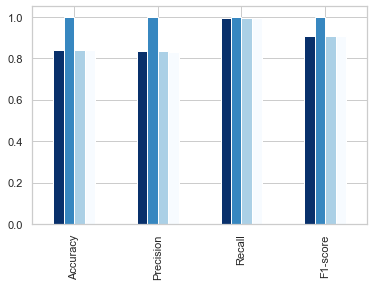

In [164]:
measures_train_df.plot(kind='bar', colormap='Blues_r', legend= False)

In [146]:
# Test performance
measures_test = {'Accuracy':[metrics.accuracy_score(y_test, y_pred_tree), metrics.accuracy_score(y_test, y_pred_rf), metrics.accuracy_score(y_test, y_pred_bagging), metrics.accuracy_score(y_test, y_pred_abc)], 
            'Precision':[metrics.precision_score(y_test, y_pred_tree), metrics.precision_score(y_test, y_pred_rf), metrics.precision_score(y_test, y_pred_bagging), metrics.precision_score(y_test, y_pred_abc)], 
           'Recall':[metrics.recall_score(y_test, y_pred_tree), metrics.recall_score(y_test, y_pred_rf), metrics.recall_score(y_test, y_pred_bagging), metrics.recall_score(y_test, y_pred_abc)], 
           'F1-score':[metrics.f1_score(y_test, y_pred_tree),metrics.f1_score(y_test, y_pred_rf),metrics.f1_score(y_test, y_pred_bagging),metrics.f1_score(y_test, y_pred_abc)]} 
measures_test_df = pd.DataFrame(measures_test, index =['Tree', 'RandomForest','Bagging', 'AdaBoosting']).transpose()
measures_test_df 

,Tree,RandomForest,Bagging,AdaBoosting
Accuracy,0.839753,0.837640,0.839753,0.838147
Precision,0.833758,0.835078,0.833768,0.832366
Recall,0.995215,0.989525,0.995198,0.995164
F1-score,0.907360,0.905765,0.907359,0.906514


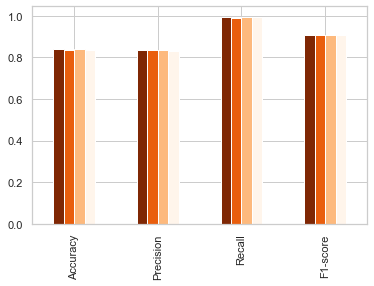

In [166]:
measures_test_df.plot(kind='bar', colormap='Oranges_r', legend= False)

#### ROC Curves

In [79]:
# Multiple ROC curves
from sklearn.metrics import roc_curve, roc_auc_score

# Instantiate the classfiers and make a list
classifiers = [rf, treeclf, Baggingclf, abc]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(x_train, y_train)
    yproba = model.predict_proba(x_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

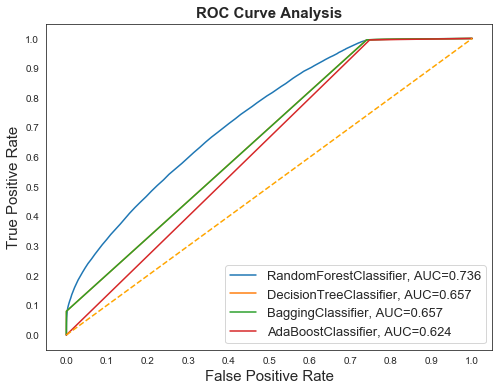

In [80]:
# Plot the ROC curve figure
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()
fig.savefig('multiple_roc_curve.png')

# Reference:
https://joshlawman.com/metrics-classification-report-breakdown-precision-recall-f1/

https://towardsdatascience.com/end-to-end-python-framework-for-predictive-modeling-b8052bb96a78

https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

https://xavierbourretsicotte.github.io/AdaBoost.html